In [1]:
import argparse
import os.path as osp
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid, CitationFull
from torch_geometric.logging import log
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SGConv, SAGEConv
from torch_geometric.utils import degree, add_remaining_self_loops, k_hop_subgraph, to_networkx
from torch_scatter import scatter
import torch_sparse
import networkx as nx

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='PubMed')
parser.add_argument('--hidden_channels', type=int, default=16)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--num_layers', type=int, default=2)
args = parser.parse_args("")

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
path = osp.join('.', 'data', 'CitationFull')
transform = T.Compose([
                T.LargestConnectedComponents(),
                T.RandomNodeSplit(),
                T.NormalizeFeatures()
            ])
dataset = CitationFull(path, args.dataset, transform=transform)
data = dataset[0].to(device)

In [5]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='gcn'):
        super().__init__()
        
        if model_type == 'gcn':
            conv = GCNConv
        else:
            conv = SGConv
        
        self.conv_list = torch.nn.ModuleList([conv(in_channels, hidden_channels)] + \
                                       [conv(hidden_channels, hidden_channels) for i in range(args.num_layers - 2)] + \
                                       [conv(hidden_channels, out_channels)])
        
        self.model_type = model_type

    def forward(self, x, edge_index, edge_weight=None):
        for idx, conv in enumerate(self.conv_list):
            # x = F.dropout(x, p=0.5, training=self.training)
            if idx != 0 and self.model_type == 'gcn':
                x = x.relu()
            x = conv(x, edge_index, edge_weight)
            
        return x

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='mlp'):
        super().__init__()
        
        self.conv_list = torch.nn.ModuleList([torch.nn.Linear(in_channels, hidden_channels)] + \
                                       [torch.nn.Linear(hidden_channels, hidden_channels) for i in range(args.num_layers - 2)] + \
                                       [torch.nn.Linear(hidden_channels, out_channels)])
        self.model_type = model_type

    def forward(self, x, edge_index, edge_weight=None):
        for idx, conv in enumerate(self.conv_list):
            # x = F.dropout(x, p=0.5, training=self.training)
            if idx != 0 and self.model_type == 'mlp':
                x = x.relu()
            x = conv(x)
            
        return x

In [6]:
def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model):
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

@torch.no_grad()
def test_err_by_deg(model):
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)
    
    edge_index, _ = add_remaining_self_loops(data.edge_index)
    edge_weight = torch.ones_like(edge_index[0]).float()
    deg = degree(edge_index[0], num_nodes=data.x.size(0))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    edge_weight = deg_inv_sqrt[edge_index[0]] * edge_weight * deg_inv_sqrt[edge_index[1]]
    
    deg = torch.zeros_like(data.y).float()
    deg = torch.scatter_add(deg, 0, edge_index[0], edge_weight)

    errs = []
    degs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        mismatches = (pred[mask] != data.y[mask]).float()
        # err = scatter(mismatches, deg[mask], reduce='mean')
        # deg_mask = torch.unique(deg[mask])
        
        errs.append(mismatches)
        degs.append(deg[mask])
    return errs, degs

@torch.no_grad()
def test_loss_by_deg(model):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    
    edge_index, _ = add_remaining_self_loops(data.edge_index)
    edge_weight = torch.ones_like(edge_index[0]).float()
    deg = degree(edge_index[0], num_nodes=data.x.size(0))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    edge_weight = deg_inv_sqrt[edge_index[0]] * edge_weight * deg_inv_sqrt[edge_index[1]]
    
    deg = torch.zeros_like(data.y).float()
    deg = torch.scatter_add(deg, 0, edge_index[0], edge_weight)
    
    c_mask = data.y[edge_index[0]] == data.y[edge_index[1]]
    homo = torch.zeros_like(data.y).float()
    homo = torch.scatter_add(homo, 0, edge_index[0, c_mask], edge_weight[c_mask]) / deg
    
#     G = to_networkx(data, to_undirected=True)
#     centrality = torch.tensor(list(nx.betweenness_centrality(G).values()))

    errs = []
    degs = []
    homos = []
    # cents = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
#         deg_mask = torch.unique(deg[mask])
#         err = torch.zeros_like(deg_mask).float()
        
#         for i, d in enumerate(deg_mask):
#             err[i] = F.cross_entropy(out[mask & (deg == d)], data.y[mask & (deg == d)])
        pred = F.log_softmax(out[mask], dim=1)
        target = data.y[mask]
        err = -pred[range(target.size(0)), target]
         
        errs.append(err)
        degs.append(deg[mask])
        homos.append(homo[mask])
        # cents.append(centrality[mask])
    return errs, degs, homos #, cents

In [7]:
def get_compatibility_matrix(y, edge_index, edge_weight=None):
    """
    Return the weighted compatibility matrix, according to the weights in the provided adjacency matrix.
    """
    src, dst = edge_index

    num_classes = torch.unique(y).shape[0]
    H = torch.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            mask = (y == i)[src] & (y == j)[dst]
            H[i, j] = edge_weight[mask].sum()

    return torch.nn.functional.normalize(H, p=1)

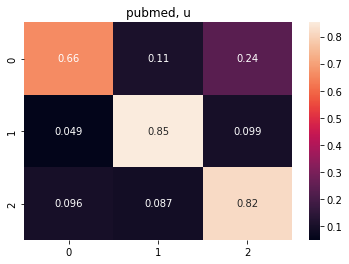

In [8]:
edge_index = data.edge_index
edge_weight = torch.ones_like(edge_index[0]).float()
C_u = get_compatibility_matrix(data.y, edge_index, edge_weight)
fig, ax = plt.subplots()
ax = sns.heatmap(C_u, annot=C_u)
plt.title(dataset.name + ", u")
plt.show()

In [9]:
gnn_model = GNN(
    in_channels=dataset.num_features,
    hidden_channels=args.hidden_channels,
    out_channels=dataset.num_classes,
).to(device)

mlp_model = MLP(
    in_channels=dataset.num_features,
    hidden_channels=args.hidden_channels,
    out_channels=dataset.num_classes,
).to(device)

for model in [gnn_model, mlp_model]:
    optimizer = torch.optim.Adam([
        dict(params=conv.parameters(), weight_decay=0) for conv in model.conv_list
    ], lr=args.lr)  # Only perform weight-decay on first convolution.

    best_val_acc = test_acc = 0
    best_model = None
    times = []
    for epoch in range(1, args.epochs + 1):
        start = time.time()
        loss = train(model)
        train_acc, val_acc, tmp_test_acc = test(model)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
            best_model = model
        log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
        times.append(time.time() - start)
    model = best_model
    print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 001, Loss: 1.0986, Train: 0.4319, Val: 0.4260, Test: 0.4450
Epoch: 002, Loss: 1.0906, Train: 0.5441, Val: 0.5280, Test: 0.5450
Epoch: 003, Loss: 1.0831, Train: 0.5894, Val: 0.6080, Test: 0.5960
Epoch: 004, Loss: 1.0760, Train: 0.5907, Val: 0.6060, Test: 0.5960
Epoch: 005, Loss: 1.0689, Train: 0.5746, Val: 0.5940, Test: 0.5960
Epoch: 006, Loss: 1.0616, Train: 0.5421, Val: 0.5640, Test: 0.5960
Epoch: 007, Loss: 1.0549, Train: 0.5170, Val: 0.5300, Test: 0.5960
Epoch: 008, Loss: 1.0490, Train: 0.5029, Val: 0.5100, Test: 0.5960
Epoch: 009, Loss: 1.0437, Train: 0.4987, Val: 0.5040, Test: 0.5960
Epoch: 010, Loss: 1.0388, Train: 0.5020, Val: 0.5060, Test: 0.5960
Epoch: 011, Loss: 1.0343, Train: 0.5101, Val: 0.5220, Test: 0.5960
Epoch: 012, Loss: 1.0300, Train: 0.5225, Val: 0.5360, Test: 0.5960
Epoch: 013, Loss: 1.0258, Train: 0.5376, Val: 0.5540, Test: 0.5960
Epoch: 014, Loss: 1.0215, Train: 0.5564, Val: 0.5780, Test: 0.5960
Epoch: 015, Loss: 1.0170, Train: 0.5769, Val: 0.5920, Test: 0.

Epoch: 134, Loss: 0.4126, Train: 0.8520, Val: 0.8580, Test: 0.8490
Epoch: 135, Loss: 0.4114, Train: 0.8526, Val: 0.8580, Test: 0.8490
Epoch: 136, Loss: 0.4102, Train: 0.8529, Val: 0.8580, Test: 0.8490
Epoch: 137, Loss: 0.4090, Train: 0.8530, Val: 0.8620, Test: 0.8500
Epoch: 138, Loss: 0.4078, Train: 0.8534, Val: 0.8620, Test: 0.8500
Epoch: 139, Loss: 0.4067, Train: 0.8535, Val: 0.8620, Test: 0.8500
Epoch: 140, Loss: 0.4056, Train: 0.8540, Val: 0.8640, Test: 0.8490
Epoch: 141, Loss: 0.4045, Train: 0.8544, Val: 0.8640, Test: 0.8490
Epoch: 142, Loss: 0.4034, Train: 0.8542, Val: 0.8640, Test: 0.8490
Epoch: 143, Loss: 0.4024, Train: 0.8546, Val: 0.8660, Test: 0.8510
Epoch: 144, Loss: 0.4013, Train: 0.8549, Val: 0.8680, Test: 0.8520
Epoch: 145, Loss: 0.4003, Train: 0.8553, Val: 0.8700, Test: 0.8520
Epoch: 146, Loss: 0.3993, Train: 0.8555, Val: 0.8700, Test: 0.8520
Epoch: 147, Loss: 0.3983, Train: 0.8556, Val: 0.8700, Test: 0.8520
Epoch: 148, Loss: 0.3973, Train: 0.8561, Val: 0.8720, Test: 0.

Epoch: 083, Loss: 0.5846, Train: 0.7974, Val: 0.8020, Test: 0.7920
Epoch: 084, Loss: 0.5788, Train: 0.7990, Val: 0.8060, Test: 0.7920
Epoch: 085, Loss: 0.5731, Train: 0.8006, Val: 0.8060, Test: 0.7920
Epoch: 086, Loss: 0.5676, Train: 0.8024, Val: 0.8060, Test: 0.7920
Epoch: 087, Loss: 0.5622, Train: 0.8036, Val: 0.8040, Test: 0.7920
Epoch: 088, Loss: 0.5570, Train: 0.8047, Val: 0.8080, Test: 0.7970
Epoch: 089, Loss: 0.5519, Train: 0.8058, Val: 0.8120, Test: 0.7980
Epoch: 090, Loss: 0.5469, Train: 0.8071, Val: 0.8120, Test: 0.7980
Epoch: 091, Loss: 0.5421, Train: 0.8083, Val: 0.8120, Test: 0.7980
Epoch: 092, Loss: 0.5374, Train: 0.8105, Val: 0.8160, Test: 0.8000
Epoch: 093, Loss: 0.5328, Train: 0.8114, Val: 0.8180, Test: 0.8010
Epoch: 094, Loss: 0.5284, Train: 0.8122, Val: 0.8200, Test: 0.8010
Epoch: 095, Loss: 0.5241, Train: 0.8137, Val: 0.8220, Test: 0.8030
Epoch: 096, Loss: 0.5199, Train: 0.8146, Val: 0.8220, Test: 0.8030
Epoch: 097, Loss: 0.5159, Train: 0.8158, Val: 0.8240, Test: 0.

# gnn errs: 2409 / 18217
gnn and mlp errs: 1437 / 18217
gnn but not mlp errs: 972 / 18217
mlp but not gnn errs: 951 / 18217
gcn err-weighted deg: 0.11118237674236298
mlp err-weighted deg: 0.11277846246957779


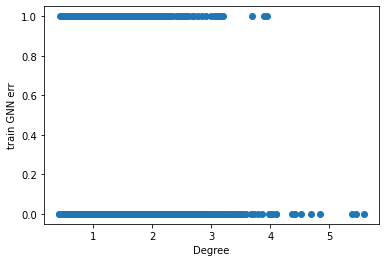

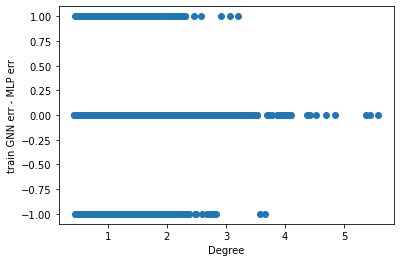

# gnn errs: 58 / 500
gnn and mlp errs: 36 / 500
gnn but not mlp errs: 22 / 500
mlp but not gnn errs: 29 / 500
gcn err-weighted deg: 0.09324058145284653
mlp err-weighted deg: 0.10363230109214783


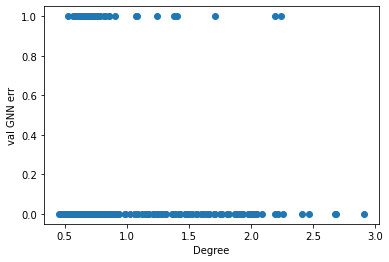

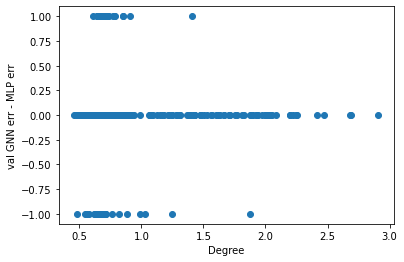

# gnn errs: 138 / 1000
gnn and mlp errs: 85 / 1000
gnn but not mlp errs: 53 / 1000
mlp but not gnn errs: 63 / 1000
gcn err-weighted deg: 0.11936713010072708
mlp err-weighted deg: 0.1316262185573578


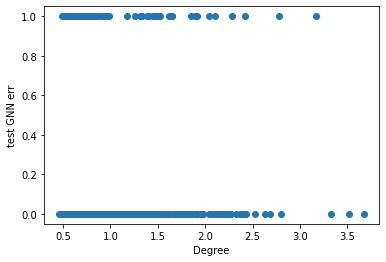

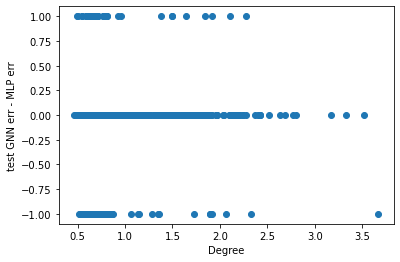

In [10]:
gnn_errs, degs = test_err_by_deg(gnn_model)
mlp_errs = test_err_by_deg(mlp_model)[0]
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    print('# gnn errs:', gnn_errs[i].sum().long().item(), '/', gnn_errs[i].size(0))
    print('gnn and mlp errs:', ((gnn_errs[i] == 1) & (mlp_errs[i] == 1)).long().sum().item(), '/', gnn_errs[i].size(0))
    
    diff = gnn_errs[i] - mlp_errs[i]
    diff[diff < 0] = 0
    print('gnn but not mlp errs:', diff.sum().long().item(), '/', diff.size(0))
    diff = mlp_errs[i] - gnn_errs[i]
    diff[diff < 0] = 0
    print('mlp but not gnn errs:', diff.sum().long().item(), '/', diff.size(0))
    
    print('gcn err-weighted deg:', (degs[i] * gnn_errs[i]).mean().item())
    print('mlp err-weighted deg:', (degs[i] * mlp_errs[i]).mean().item())
    
    plt.scatter(degs[i].tolist(), gnn_errs[i].tolist())
    plt.xlabel('Degree')
    plt.ylabel('{} GNN err'.format(split))
    plt.show()
    
    plt.scatter(degs[i].tolist(), (gnn_errs[i] - mlp_errs[i]).tolist())
    plt.xlabel('Degree')
    plt.ylabel('{} GNN err - MLP err'.format(split))
    plt.show()

In [11]:
edge_index, _ = add_remaining_self_loops(data.edge_index)
edge_weight = torch.ones_like(edge_index[0]).float()
deg = degree(edge_index[0], num_nodes=data.x.size(0))
deg_inv_sqrt = deg.pow(-0.5)
deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
edge_weight = deg_inv_sqrt[edge_index[0]] * edge_weight * deg_inv_sqrt[edge_index[1]]
x_agg = torch_sparse.spmm(edge_index, edge_weight, data.x.size(0), data.x.size(0), data.x)

# of training points: 19717
Rank of X: 500
Rank of AX: 500


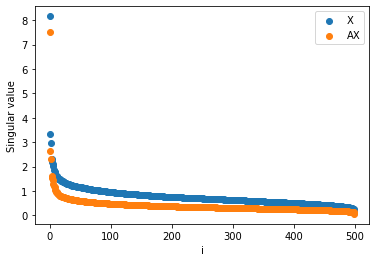

In [12]:
print('# of training points:', data.train_mask.size(0))

x_s = torch.linalg.svdvals(data.x[data.train_mask])
print('Rank of X:', torch.linalg.matrix_rank(data.x[data.train_mask]).item())
plt.scatter(range(x_s.size(0)), x_s.tolist(), label='X')

x_agg_s = torch.linalg.svdvals(x_agg[data.train_mask])
print('Rank of AX:', torch.linalg.matrix_rank(x_agg[data.train_mask]).item())
plt.scatter(range(x_agg_s.size(0)), x_agg_s.tolist(), label='AX')

plt.xlabel('i')
plt.ylabel('Singular value')
plt.legend()
plt.show()

# adj = torch_sparse.spmm(edge_index, edge_weight, data.x.size(0), data.x.size(0), torch.eye(data.x.size(0)).to(device))
# adj_s = torch.linalg.svdvals(adj)
# plt.scatter(range(adj_s.size(0)), adj_s.tolist())
# plt.show()

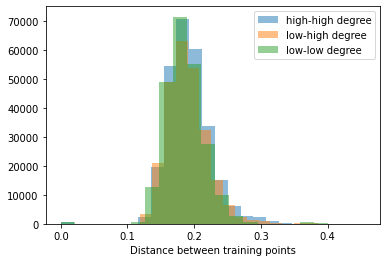

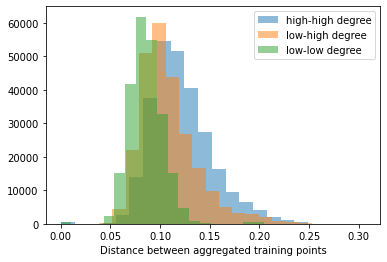

In [13]:
mask = data.test_mask
degs_split = degs[2]
cutoff = torch.median(degs_split)

dist = torch.cdist(data.x[mask][degs_split >= cutoff].unsqueeze(0), data.x[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='high-high degree')
dist = torch.cdist(data.x[mask][degs_split < cutoff].unsqueeze(0), data.x[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-high degree')
dist = torch.cdist(data.x[mask][degs_split < cutoff].unsqueeze(0), data.x[mask][degs_split < cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-low degree')
plt.xlabel('Distance between training points')
plt.legend()
plt.show()

dist = torch.cdist(x_agg[mask][degs_split >= cutoff].unsqueeze(0), x_agg[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='high-high degree')
dist = torch.cdist(x_agg[mask][degs_split < cutoff].unsqueeze(0), x_agg[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-high degree')
dist = torch.cdist(x_agg[mask][degs_split < cutoff].unsqueeze(0), x_agg[mask][degs_split < cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-low degree')
plt.xlabel('Distance between aggregated training points')
plt.legend()
plt.show()

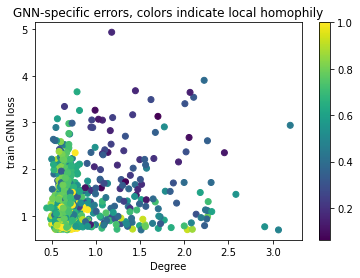

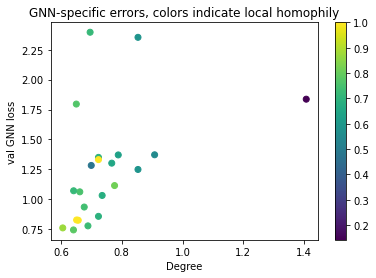

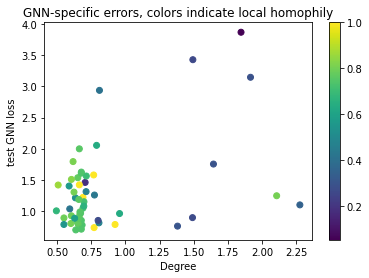

In [14]:
gnn_losses, degs, homos = test_loss_by_deg(gnn_model)
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    diff_mask = (gnn_errs[i] == 1) & (mlp_errs[i] == 0)
    
    plt.scatter(degs[i][diff_mask].tolist(), gnn_losses[i][diff_mask].tolist(), c=homos[i][diff_mask].tolist())
    plt.colorbar()
    plt.xlabel('Degree')
    plt.ylabel('{} GNN loss'.format(split))
    plt.title('GNN-specific errors, colors indicate local homophily')
    plt.show()

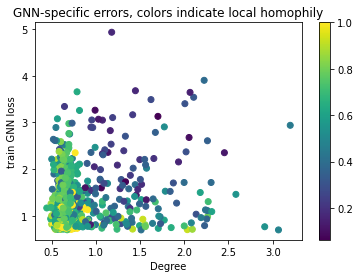

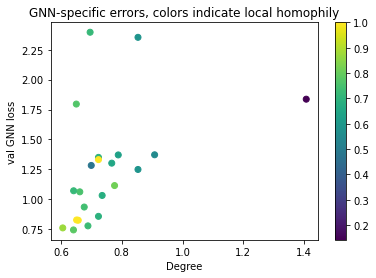

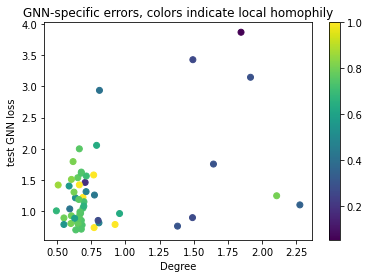

In [15]:
gnn_losses, degs, homos = test_loss_by_deg(gnn_model)
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    diff_mask = (gnn_errs[i] == 1) & (mlp_errs[i] == 0)
    
    plt.scatter(degs[i][diff_mask].tolist(), gnn_losses[i][diff_mask].tolist(), c=homos[i][diff_mask].tolist())
    plt.colorbar()
    plt.xlabel('Degree')
    plt.ylabel('{} GNN loss'.format(split))
    plt.title('GNN-specific errors, colors indicate local homophily')
    plt.show()

In [42]:
def influence_scores():
    edge_index, _ = add_remaining_self_loops(data.edge_index)
    edge_weight = torch.ones_like(edge_index[0]).float()
    deg = degree(edge_index[0], num_nodes=data.x.size(0))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    edge_weight = deg_inv_sqrt[edge_index[0]] * edge_weight * deg_inv_sqrt[edge_index[1]]
    
    deg = torch.zeros_like(data.y).float()
    deg = torch.scatter_add(deg, 0, edge_index[0], edge_weight)
    
    for _ in range(args.num_layers - 1):
        edge_index, edge_weight = torch_sparse.spspmm(edge_index, edge_weight, edge_index, edge_weight, data.x.size(0), data.x.size(0), data.x.size(0))
    labeled_idx = data.train_mask.float().reshape(-1, 1)
    total_influence = torch_sparse.spmm(edge_index, edge_weight, data.x.size(0), data.x.size(0), labeled_idx).flatten()
    self_influence = edge_weight[edge_index[0] == edge_index[1]] 
    return total_influence

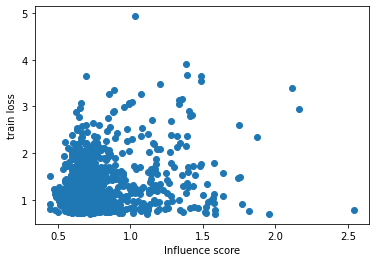

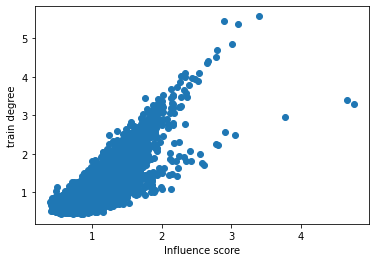

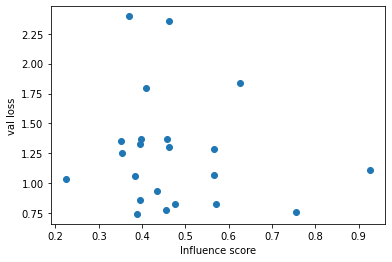

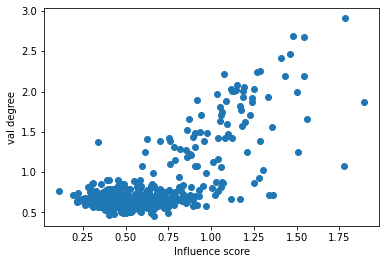

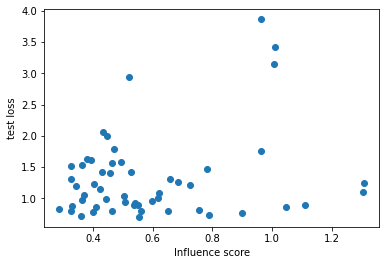

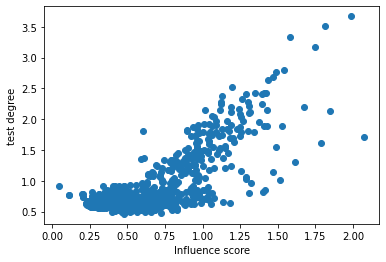

In [43]:
infl = influence_scores()
infl_list = [infl[mask] for mask in [data.train_mask, data.val_mask, data.test_mask]]
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    diff_mask = (gnn_errs[i] == 1) & (mlp_errs[i] == 0)
    
    plt.scatter(infl_list[i][diff_mask].tolist(), gnn_losses[i][diff_mask].tolist())
    plt.xlabel('Influence score')
    plt.ylabel('{} loss'.format(split))
    plt.show()
    
    plt.scatter(infl_list[i].tolist(), degs[i].tolist())
    plt.xlabel('Influence score')
    plt.ylabel('{} degree'.format(split))
    plt.show()

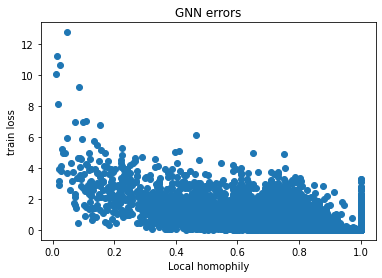

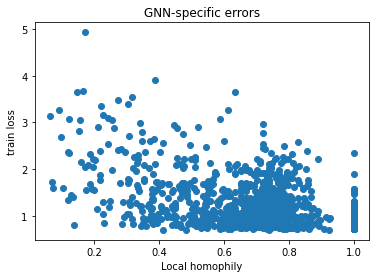

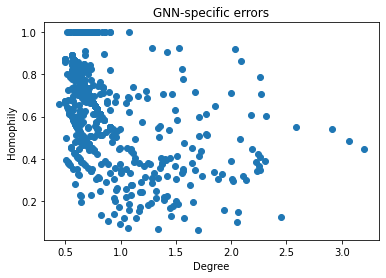

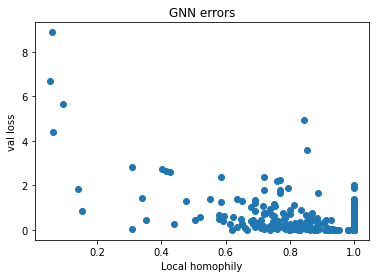

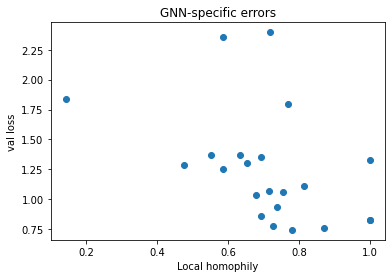

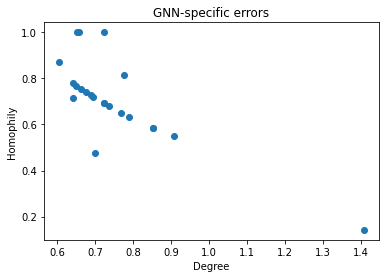

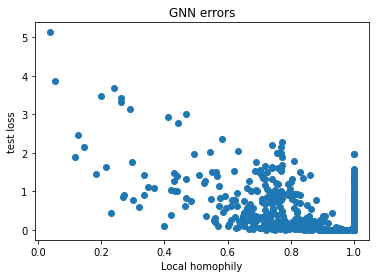

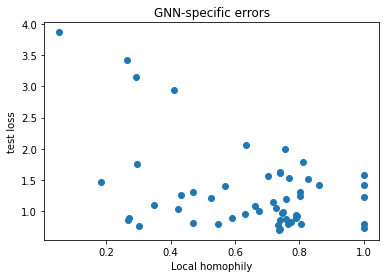

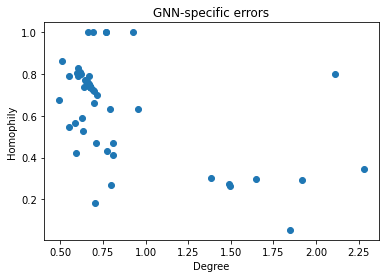

In [18]:
# https://arxiv.org/pdf/2306.05557.pdf
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    diff_mask = (gnn_errs[i] == 1) & (mlp_errs[i] == 0)
    
    plt.scatter(homos[i].tolist(), gnn_losses[i].tolist())
    plt.xlabel('Local homophily')
    plt.ylabel('{} loss'.format(split))
    plt.title('GNN errors')
    plt.show()
    
    plt.scatter(homos[i][diff_mask].tolist(), gnn_losses[i][diff_mask].tolist())
    plt.xlabel('Local homophily')
    plt.ylabel('{} loss'.format(split))
    plt.title('GNN-specific errors')
    plt.show()
    
    plt.scatter(degs[i][diff_mask].tolist(), homos[i][diff_mask].tolist())
    plt.xlabel('Degree')
    plt.ylabel('Homophily')
    plt.title('GNN-specific errors')
    plt.show()

In [19]:
@torch.no_grad()
def get_dists(model):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    
    dists = torch.cdist(out.unsqueeze(0), out.unsqueeze(0), p=2).squeeze(0)
    # closest_points = data.train_mask.nonzero().flatten()[torch.argmax(dists, dim=-1)]
    # return closest_points
    return dists

In [20]:
model = gnn_model
dists = get_dists(model)
deg = degree(data.edge_index[0], num_nodes=data.x.size(0)).long()

closest = dists[data.test_mask][:, data.train_mask].argmin(dim=1)
class_eq = (data.y[data.test_mask].reshape(-1, 1) == data.y[data.train_mask].reshape(1, -1)).float()
print(class_eq[torch.arange(closest.size(0)), closest].mean())

print(torch.unique(data.train_mask.nonzero().flatten()[closest]).size(0))

print(float(torch.unique(closest).size(0)) / data.train_mask.sum())

tensor(0.7980, device='cuda:0')
963
tensor(0.0529, device='cuda:0')


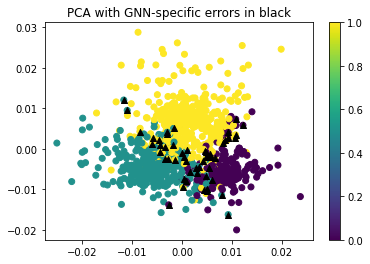

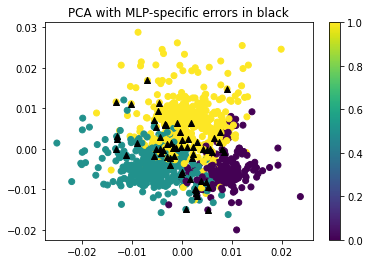

In [21]:
out = model(data.x, data.edge_index, data.edge_attr)
U, S, V = torch.pca_lowrank(out, q = 2)

diff_mask = (gnn_errs[-1] == 1) & (mlp_errs[-1] == 0)
plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=data.y[data.test_mask].tolist())
plt.scatter(U[:, 0][data.test_mask][diff_mask].tolist(), U[:, 1][data.test_mask][diff_mask].tolist(), c='k', marker='^')
plt.colorbar()
plt.title('PCA with GNN-specific errors in black')
plt.show()

diff_mask = (gnn_errs[-1] == 0) & (mlp_errs[-1] == 1)
plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=data.y[data.test_mask].tolist())
plt.scatter(U[:, 0][data.test_mask][diff_mask].tolist(), U[:, 1][data.test_mask][diff_mask].tolist(), c='k', marker='^')
plt.colorbar()
plt.title('PCA with MLP-specific errors in black')
plt.show()

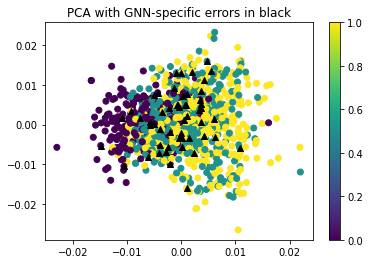

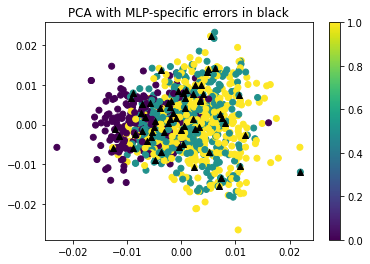

In [22]:
U, S, V = torch.pca_lowrank(data.x, q = 2)

diff_mask = (gnn_errs[-1] == 1) & (mlp_errs[-1] == 0)
plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=data.y[data.test_mask].tolist())
plt.scatter(U[:, 0][data.test_mask][diff_mask].tolist(), U[:, 1][data.test_mask][diff_mask].tolist(), c='k', marker='^')
plt.colorbar()
plt.title('PCA with GNN-specific errors in black')
plt.show()

diff_mask = (gnn_errs[-1] == 0) & (mlp_errs[-1] == 1)
plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=data.y[data.test_mask].tolist())
plt.scatter(U[:, 0][data.test_mask][diff_mask].tolist(), U[:, 1][data.test_mask][diff_mask].tolist(), c='k', marker='^')
plt.colorbar()
plt.title('PCA with MLP-specific errors in black')
plt.show()

Local homophily: 0.0541299507021904
Degree: 1.8474061489105225
Influence: 0.9638925194740295
Seed: 10
Pred: 0
Target: 1


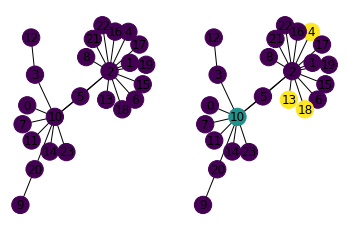

Local homophily: 0.18485720455646515
Degree: 0.7048637270927429
Influence: 0.7813321948051453
Seed: 131
Pred: 2
Target: 0


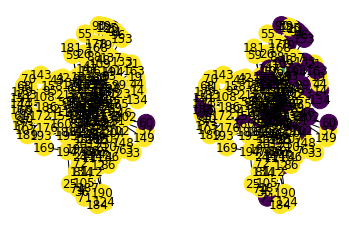

Local homophily: 0.2636871337890625
Degree: 1.494352102279663
Influence: 1.0086724758148193
Seed: 35
Pred: 1
Target: 0


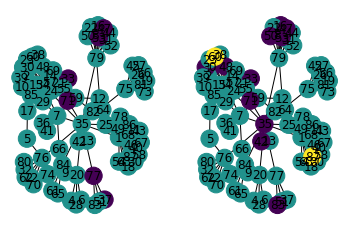

Local homophily: 0.2686782479286194
Degree: 0.7997978925704956
Influence: 1.0449283123016357
Seed: 72
Pred: 1
Target: 2


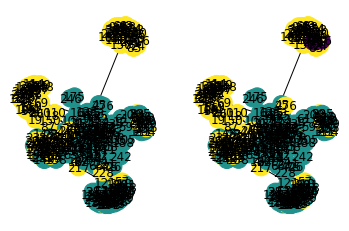

Local homophily: 0.2717115879058838
Degree: 1.4916868209838867
Influence: 1.1103153228759766
Seed: 30
Pred: 2
Target: 1


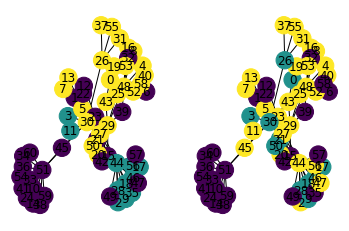

Local homophily: 0.29067766666412354
Degree: 1.9169071912765503
Influence: 1.006589412689209
Seed: 18
Pred: 0
Target: 1


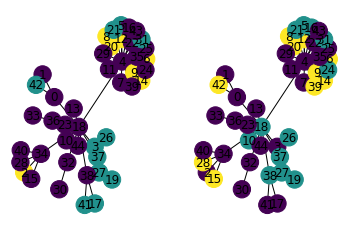

Local homophily: 0.2961299419403076
Degree: 1.645351767539978
Influence: 0.9638525247573853
Seed: 9
Pred: 2
Target: 1


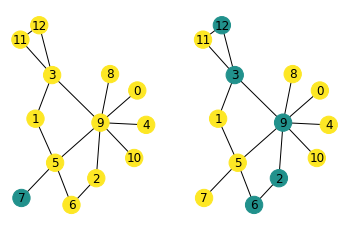

Local homophily: 0.30211904644966125
Degree: 1.3819468021392822
Influence: 0.8988910913467407
Seed: 6
Pred: 2
Target: 0


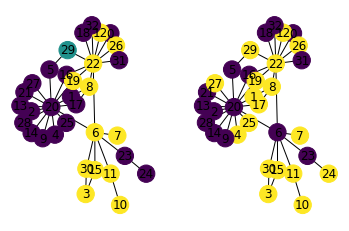

Local homophily: 0.3478679060935974
Degree: 2.278676986694336
Influence: 1.3036624193191528
Seed: 5
Pred: 0
Target: 2


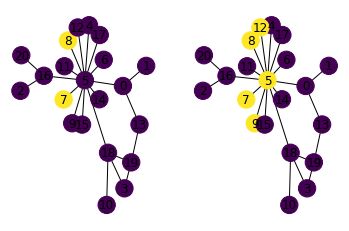

Local homophily: 0.411649614572525
Degree: 0.8097500801086426
Influence: 0.5210882425308228
Seed: 5
Pred: 1
Target: 2


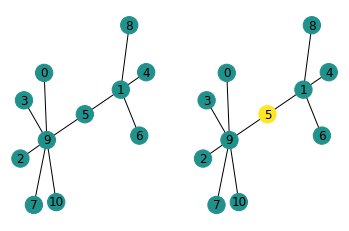

Local homophily: 0.42234206199645996
Degree: 0.591937243938446
Influence: 0.5052694082260132
Seed: 56
Pred: 2
Target: 0


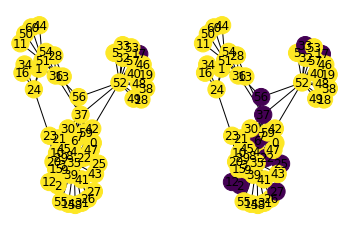

Local homophily: 0.4311312735080719
Degree: 0.7731596827507019
Influence: 0.6859580278396606
Seed: 4
Pred: 0
Target: 1


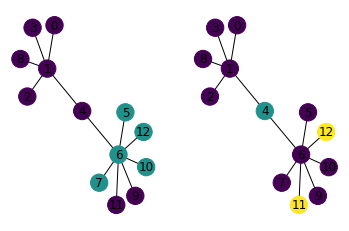

Local homophily: 0.46837571263313293
Degree: 0.7116793394088745
Influence: 0.6572815775871277
Seed: 1
Pred: 2
Target: 1


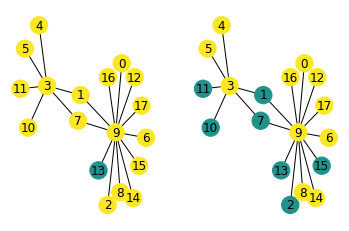

Local homophily: 0.4689584970474243
Degree: 0.8061127066612244
Influence: 0.7544342875480652
Seed: 23
Pred: 2
Target: 0


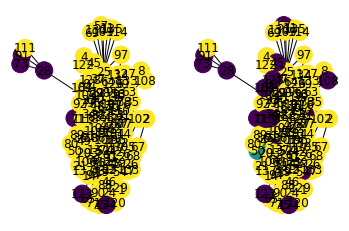

Local homophily: 0.5261860489845276
Degree: 0.6334894895553589
Influence: 0.7260195016860962
Seed: 25
Pred: 1
Target: 2


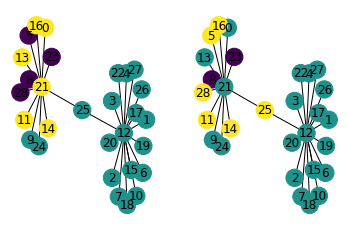

Local homophily: 0.5464441776275635
Degree: 0.5490038394927979
Influence: 0.4653365910053253
Seed: 80
Pred: 2
Target: 0


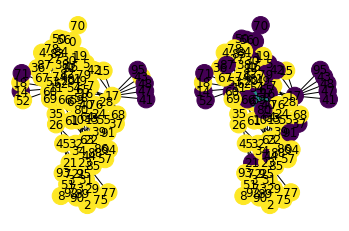

Local homophily: 0.5676007270812988
Degree: 0.5872672200202942
Influence: 0.4580758810043335
Seed: 34
Pred: 1
Target: 0


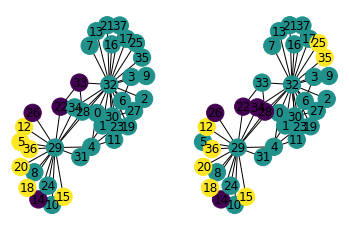

Local homophily: 0.591384768486023
Degree: 0.6277939677238464
Influence: 0.5502893328666687
Seed: 36
Pred: 0
Target: 2


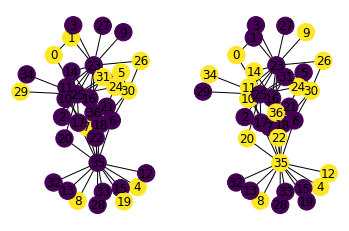

Local homophily: 0.6306019425392151
Degree: 0.9571067094802856
Influence: 0.5990355014801025
Seed: 7
Pred: 2
Target: 1


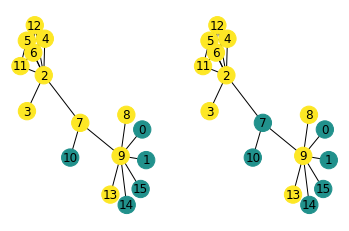

Local homophily: 0.6339746117591858
Degree: 0.7886750102043152
Influence: 0.4339337944984436
Seed: 3
Pred: 0
Target: 1


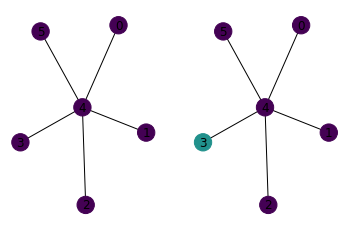

Local homophily: 0.6608716249465942
Degree: 0.6950237154960632
Influence: 0.6209939122200012
Seed: 22
Pred: 1
Target: 2


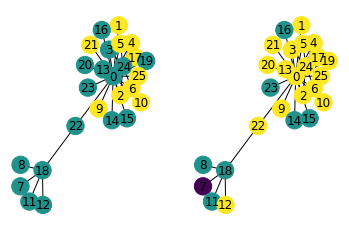

Local homophily: 0.6748766303062439
Degree: 0.49391740560531616
Influence: 0.6195569038391113
Seed: 67
Pred: 2
Target: 0


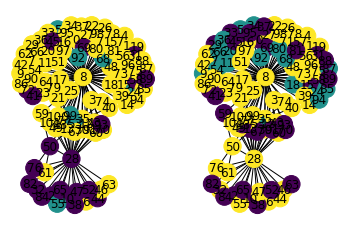

Local homophily: 0.7010648846626282
Degree: 0.7132006287574768
Influence: 0.4641256630420685
Seed: 9
Pred: 0
Target: 1


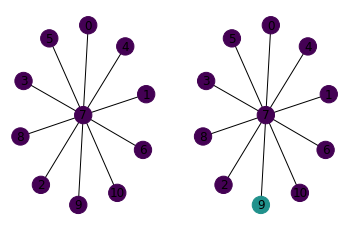

Local homophily: 0.7182709574699402
Degree: 0.696116030216217
Influence: 0.424083411693573
Seed: 7
Pred: 2
Target: 0


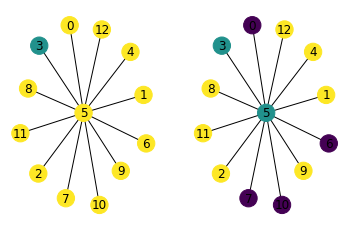

Local homophily: 0.7257081270217896
Degree: 0.6889821290969849
Influence: 0.3696950674057007
Seed: 10
Pred: 1
Target: 0


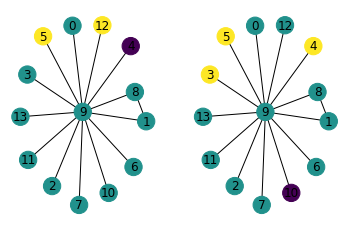

Local homophily: 0.7325210571289062
Degree: 0.6825740933418274
Influence: 0.3999999761581421
Seed: 2
Pred: 1
Target: 2


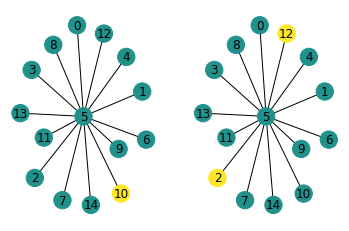

Local homophily: 0.737979531288147
Degree: 0.6360827684402466
Influence: 0.5541338920593262
Seed: 25
Pred: 1
Target: 2


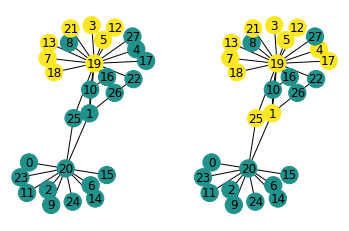

Local homophily: 0.7387961149215698
Degree: 0.6767765879631042
Influence: 0.410154789686203
Seed: 2
Pred: 0
Target: 2


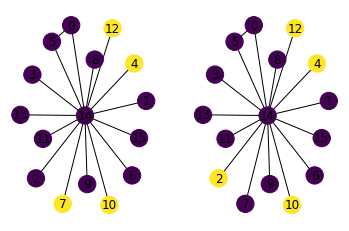

Local homophily: 0.7387961149215698
Degree: 0.6767765879631042
Influence: 0.36153730750083923
Seed: 14
Pred: 0
Target: 2


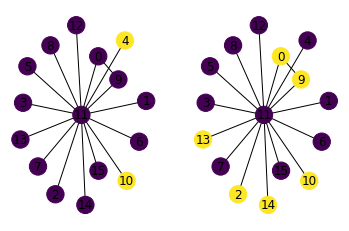

Local homophily: 0.7387961149215698
Degree: 0.6767765879631042
Influence: 0.3809664249420166
Seed: 12
Pred: 1
Target: 0


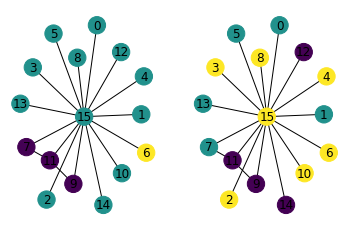

Local homophily: 0.7387961149215698
Degree: 0.6767765879631042
Influence: 0.3941100239753723
Seed: 1
Pred: 0
Target: 1


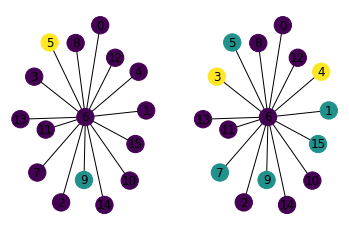

Local homophily: 0.7446032166481018
Degree: 0.6714984774589539
Influence: 0.3626028597354889
Seed: 11
Pred: 1
Target: 2


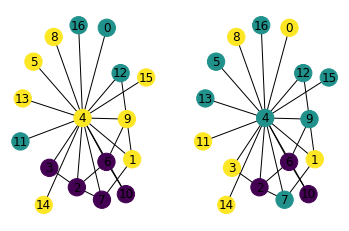

Local homophily: 0.75
Degree: 0.666666567325592
Influence: 0.445123553276062
Seed: 16
Pred: 0
Target: 2


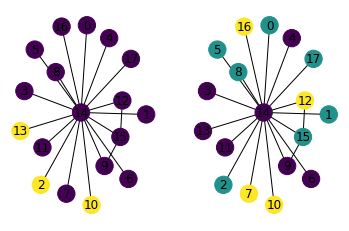

Local homophily: 0.7550344467163086
Degree: 0.6622213125228882
Influence: 0.44749915599823
Seed: 14
Pred: 2
Target: 1


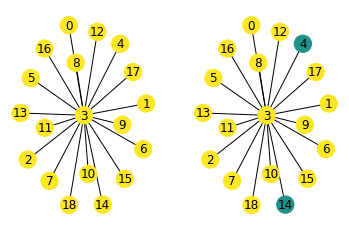

Local homophily: 0.7597469091415405
Degree: 0.6581137776374817
Influence: 0.34194692969322205
Seed: 19
Pred: 0
Target: 1


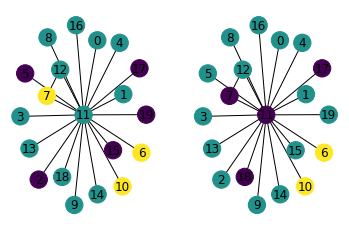

Local homophily: 0.7597469091415405
Degree: 0.6581137776374817
Influence: 0.33009859919548035
Seed: 16
Pred: 0
Target: 2


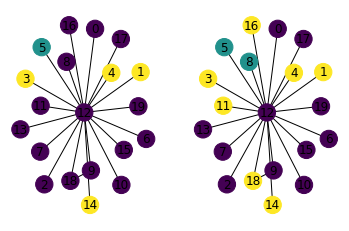

Local homophily: 0.7641715407371521
Degree: 0.654303252696991
Influence: 0.3263762891292572
Seed: 10
Pred: 2
Target: 0


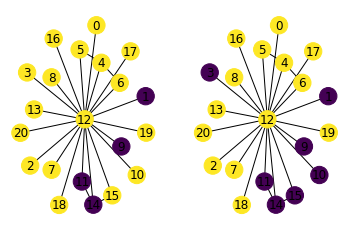

Local homophily: 0.7683375477790833
Degree: 0.6507555246353149
Influence: 0.3639650344848633
Seed: 6
Pred: 0
Target: 2


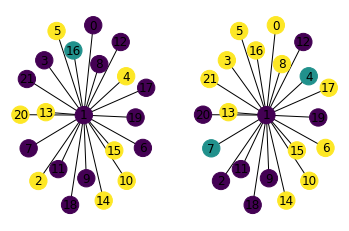

Local homophily: 0.7722699642181396
Degree: 0.6474418640136719
Influence: 0.2880870997905731
Seed: 20
Pred: 1
Target: 2


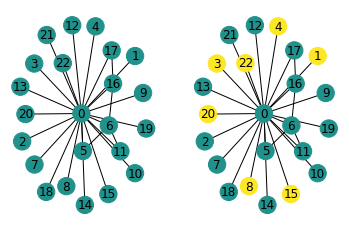

Local homophily: 0.7896881699562073
Degree: 0.6658114194869995
Influence: 0.5090715885162354
Seed: 5
Pred: 0
Target: 1


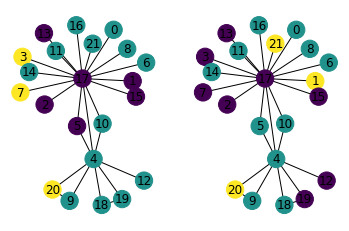

Local homophily: 0.7897896766662598
Degree: 0.549307107925415
Influence: 0.5379760265350342
Seed: 27
Pred: 1
Target: 2


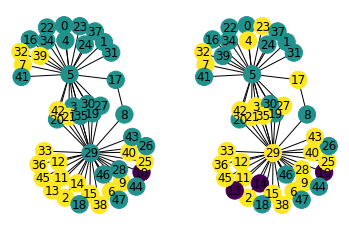

Local homophily: 0.7912925481796265
Degree: 0.6036590337753296
Influence: 0.5414600968360901
Seed: 11
Pred: 0
Target: 2


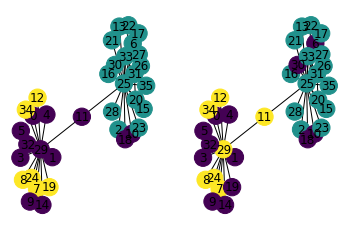

Local homophily: 0.801228404045105
Degree: 2.1085736751556396
Influence: 1.3067151308059692
Seed: 64
Pred: 2
Target: 1


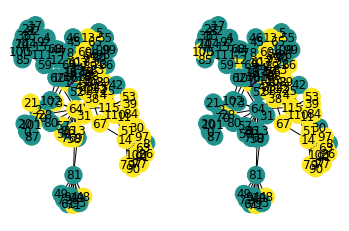

Local homophily: 0.8024503588676453
Degree: 0.6230913996696472
Influence: 0.3259654939174652
Seed: 30
Pred: 1
Target: 2


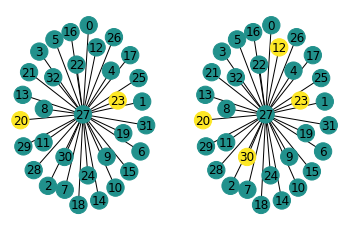

Local homophily: 0.8036651611328125
Degree: 0.6002556085586548
Influence: 0.6522408127784729
Seed: 20
Pred: 2
Target: 1


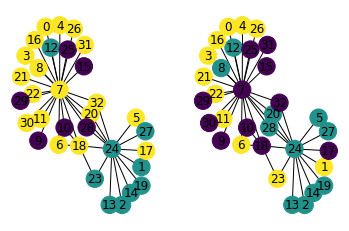

Local homophily: 0.8113621473312378
Degree: 0.6162475347518921
Influence: 0.4711796045303345
Seed: 0
Pred: 1
Target: 0


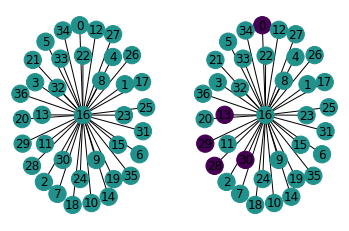

Local homophily: 0.8274621963500977
Degree: 0.6042571067810059
Influence: 0.3260020911693573
Seed: 8
Pred: 1
Target: 2


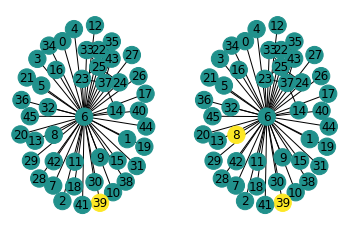

Local homophily: 0.8619168996810913
Degree: 0.5070424675941467
Influence: 0.5274510979652405
Seed: 83
Pred: 1
Target: 2


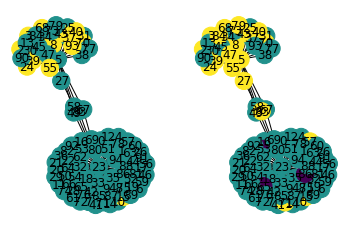

Local homophily: 1.0
Degree: 0.7672611474990845
Influence: 0.4949251413345337
Seed: 4
Pred: 0
Target: 1


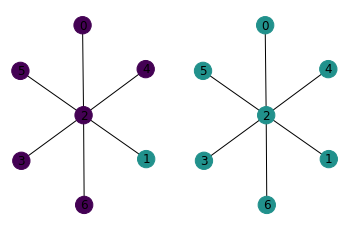

Local homophily: 1.0
Degree: 0.6622213125228882
Influence: 0.4317663908004761
Seed: 18
Pred: 2
Target: 1


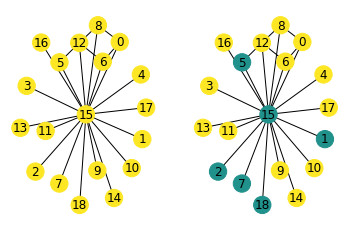

Local homophily: 1.0
Degree: 0.9241557717323303
Influence: 0.5604017376899719
Seed: 2
Pred: 2
Target: 0


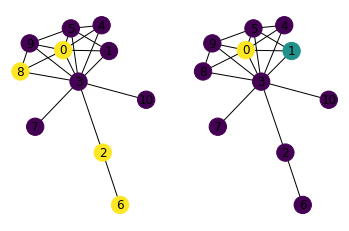

Local homophily: 1.0
Degree: 0.770439863204956
Influence: 0.7887776494026184
Seed: 15
Pred: 0
Target: 2


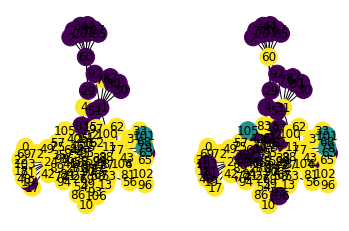

Local homophily: 1.0
Degree: 0.6889821290969849
Influence: 0.40426719188690186
Seed: 1
Pred: 2
Target: 1


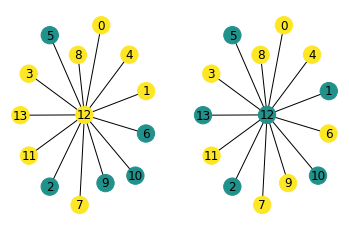

In [44]:
out = model(data.x, data.edge_index, data.edge_attr)
pred = out.argmax(dim=-1)
target = data.y
diff_mask = (gnn_errs[-1] == 1) & (mlp_errs[-1] == 0)
test_idx = data.test_mask.nonzero().flatten()

order = torch.argsort(homos[2])
new_test_idx = test_idx[order]
new_diff_mask = diff_mask[order]
new_homos = homos[2][order]
new_degs = degs[2][order]
new_infl = infl_list[2][order]

for j, i in enumerate(new_test_idx):
    if not new_diff_mask[j]:
        continue
    
    print('Local homophily:', new_homos[j].item())
    print('Degree:', new_degs[j].item())
    print('Influence:', new_infl[j].item())
    if pred[i] == target[i]:
        continue
    
    subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(i.item(), 2, data.edge_index, relabel_nodes=True)
    pred_colors = pred[subset]
    target_colors = target[subset]
    
    print('Seed:', mapping[0].item())
    print('Pred:', pred[i].item())
    print('Target:', target[i].item())
    
    sub_data = Data(edge_index=sub_edge_index, num_nodes=subset.size(0))
    G = to_networkx(sub_data, to_undirected=True)
        
    pos = nx.spring_layout(G=G, seed=42)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.flatten()
    nx.draw(G, ax=ax[0], pos=pos, node_color=pred_colors.tolist(), with_labels = True, vmin=0, vmax=data.y.max())
    nx.draw(G, ax=ax[1], pos=pos, node_color=target_colors.tolist(), with_labels = True, vmin=0, vmax=data.y.max())
    plt.show()

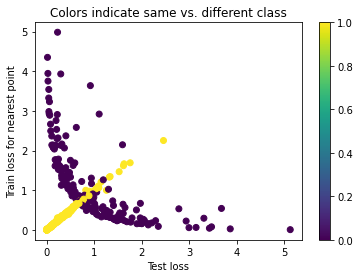

In [24]:
train_err, _, test_err = test_loss_by_deg(model)[0]
min_dists = dists[data.test_mask][:, data.train_mask].min(dim=1)[0]
closest = dists[data.test_mask][:, data.train_mask].argmin(dim=1)

class_eq = (data.y[data.test_mask].reshape(-1, 1) == data.y[data.train_mask].reshape(1, -1)).float()
same_class = class_eq[torch.arange(closest.size(0)), closest].long()

# plt.scatter(test_err.tolist(), min_dists.tolist())
# plt.show()

plt.scatter(test_err.tolist(), train_err[closest].tolist(), c=same_class.tolist())
plt.xlabel('Test loss')
plt.ylabel('Train loss for nearest point')
plt.title('Colors indicate same vs. different class')
plt.colorbar()
plt.show()

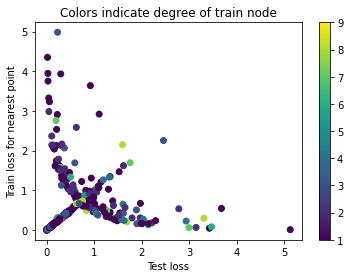

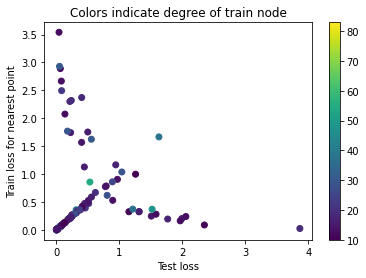

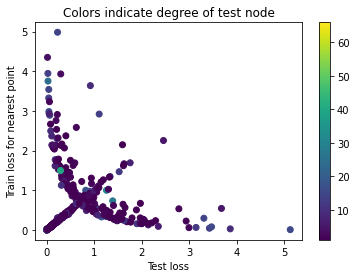

In [25]:
for cutoff in [10]:
    deg_closest = deg[closest]
    plt.scatter(test_err[deg_closest < cutoff].tolist(), train_err[closest][deg_closest < cutoff].tolist(), c=deg_closest[deg_closest < cutoff].tolist())
    plt.xlabel('Test loss')
    plt.ylabel('Train loss for nearest point')
    plt.title('Colors indicate degree of train node')
    plt.colorbar()
    plt.show()

    plt.scatter(test_err[deg_closest >= cutoff].tolist(), train_err[closest][deg_closest >= cutoff].tolist(), c=deg_closest[deg_closest >= cutoff].tolist())
    plt.xlabel('Test loss')
    plt.ylabel('Train loss for nearest point')
    plt.title('Colors indicate degree of train node')
    plt.colorbar()
    plt.show()

test_deg = deg[data.test_mask]
plt.scatter(test_err.tolist(), train_err[closest].tolist(), c=deg[data.test_mask].tolist())
plt.xlabel('Test loss')
plt.ylabel('Train loss for nearest point')
plt.title('Colors indicate degree of test node')
plt.colorbar()
plt.show()

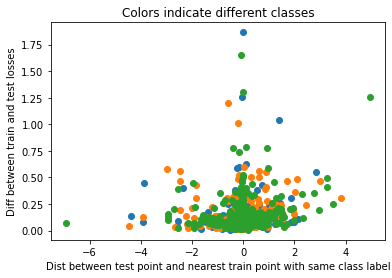

In [26]:
import math

for c in range(data.y.max() + 1):
    c_test_mask = (data.y == c) & data.test_mask
    c_train_mask = (data.y == c) & data.train_mask
    c_min_dists = dists[c_test_mask][:, c_train_mask].min(dim=1)[0]
    c_closest = dists[c_test_mask][:, c_train_mask].argmin(dim=1)
    
    plt.scatter((test_err[data.y[data.test_mask] == c] - train_err[c_closest]).tolist(), (math.sqrt(2) * c_min_dists).tolist())

plt.xlabel('Dist between test point and nearest train point with same class label') 
plt.ylabel('Diff between train and test losses')
plt.title('Colors indicate different classes')
plt.show()

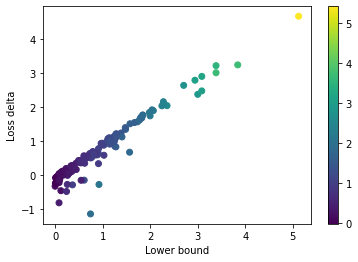

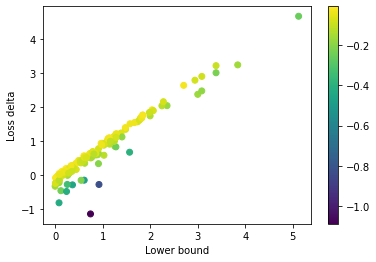

In [27]:
import math

with torch.no_grad():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out[data.test_mask].argmax(dim=-1)
    target = data.y[data.test_mask]
    
    mask = pred != target
    logits = F.log_softmax(out[data.test_mask][mask], dim=1)
    pred = pred[mask]
    target = target[mask]

    err_pred = -logits[range(pred.size(0)), pred]
    err_target = -logits[range(target.size(0)), target]
    err_diff = err_target - err_pred
    
    train_logits = F.log_softmax(out[data.train_mask], dim=1)
    scores = torch.zeros_like(err_diff)
    train_losses = torch.zeros_like(err_diff)
    train_diff = torch.zeros_like(err_diff)
    for i in range(target.size(0)):
        c = target[i]
        c_p = pred[i]
        
        train_target = data.y[data.train_mask]
        c_p_mask = train_target == c_p
        train_c_p = c_p * torch.ones_like(train_target[c_p_mask])
        train_c = c * torch.ones_like(train_target[c_p_mask])
        
        err_c_p = -train_logits[c_p_mask][range(train_c_p.size(0)), train_c_p]
        err_c = -train_logits[c_p_mask][range(train_c.size(0)), train_c]
        
        dists = torch.norm(out[data.train_mask][c_p_mask] - out[data.test_mask][mask][i].reshape(1, -1), dim=1)
        scores[i] = torch.max(err_c - err_c_p - 2 * math.sqrt(2) * dists)
        train_losses[i] = (err_c - err_c_p)[torch.argmax(err_c - err_c_p - 2 * math.sqrt(2) * dists)]
        train_diff[i] = -dists[torch.argmax(err_c - err_c_p - 2 * math.sqrt(2) * dists)]
    
#     plt.scatter(err_diff.tolist(), scores.tolist(), c=deg[data.test_mask][mask].tolist())
    plt.scatter(err_diff.tolist(), scores.tolist(), c=train_losses.tolist())
    plt.xlabel('Lower bound')
    plt.ylabel('Loss delta')
    plt.colorbar()
    plt.show()
    
    plt.scatter(err_diff.tolist(), scores.tolist(), c=train_diff.tolist())
    plt.xlabel('Lower bound')
    plt.ylabel('Loss delta')
    plt.colorbar()
    plt.show()

In [28]:
# TODO: check if GNN-specific errors are conncected to high-degree nodes
# 2-hop neighborhood will be quite large
# disaggregate low-degree errors

# TODO: there is always a chance that nodes will be right/wrong

# TODO: analyze k-hop neighbor homophily

# TODO: use embeddings from MLP as well

In [29]:
# closest = dists[data.test_mask][:, data.train_mask].argmin(dim=1)
# plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=closest.tolist())

In [30]:
# plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=deg[data.test_mask].tolist())

In [31]:
# plt.hist(deg[data.test_mask].cpu())
# plt.xlabel('Test node degree')
# plt.ylabel('Count')
# plt.show()

# plt.hist(deg[data.train_mask].cpu())
# plt.xlabel('Train node degree')
# plt.ylabel('Count')
# plt.show()

In [32]:
# closest = dists[data.test_mask][:, data.train_mask].argmin(dim=1)

# plt.scatter(deg[data.test_mask].cpu(), deg[data.train_mask.nonzero().flatten()[closest]].cpu())
# plt.xlabel('Test node degree')
# plt.ylabel('Train node degree')
# plt.title('All classes')
# plt.show()

# plt.scatter(deg[data.test_mask].cpu(), data.train_mask.nonzero().flatten()[closest].cpu())
# plt.xlabel('Test node degree')
# plt.ylabel('Train node label')
# plt.title('All classes')
# plt.show()

In [33]:
# dists = get_dists(model)
# deg = degree(data.edge_index[0], num_nodes=data.x.size(0)).long()

# for c in range(data.y.max() + 1):
#     c_test_mask = (data.y == c) & data.test_mask
#     c_train_mask = (data.y == c) & data.train_mask
#     closest = dists[c_test_mask][:, c_train_mask].argmin(dim=1)
    
#     plt.scatter(deg[c_test_mask].cpu(), deg[c_train_mask.nonzero().flatten()[closest]].cpu())
#     plt.xlabel('Test node degree')
#     plt.ylabel('Train node degree')
#     plt.title('Class {}'.format(c))
#     plt.show()
    
#     plt.scatter(deg[c_test_mask].cpu(), c_train_mask.nonzero().flatten()[closest].cpu())
#     plt.xlabel('Test node degree')
#     plt.ylabel('Train node label')
#     plt.title('Class {}'.format(c))
#     plt.show()

In [34]:
# def estimate_grad(model):
#     optimizer.zero_grad()
#     out = model(data.x, data.edge_index, data.edge_attr)
#     loss = F.cross_entropy(out[data.test_mask], data.y[data.test_mask])
#     loss.backward()
    
#     real_grads = []
#     for conv in [model.conv1, model.conv2]:
#         real_grads.append(conv.lin.weight.grad)
    
#     weights_prod = model.conv2.lin.weight @ model.conv1.lin.weight
#     print(weights_prod.size())